# Problem setting

## Game rules

This "game" is played on a grid of squares.  The starting configuation is a single occupied square.  The probability for new squares depends on the number of neighboring occupied squares.  The probability for occupying a new square is 0 for squares without any occupied neighbors, for each neighbor an empty square has, the probability goes up by 1.

That means that when there is a single square, each of its four neighbors has a 0.25 probability of being occupied.

![probabilities](game.png)

For the configuration above, the squares labeled with 1 to 7 are candiates to be a new occupied square.  Square 7 has two neighbors, so the probability to be picked is twice that of the squares 1 to 6 since those have a single neighbor each.

## Measure

The measure of interest is the "hairiness", which is defined as the number of free edges devide by the number occupied squares.  In the configuration above, the three occupied squares have 8 edges, so the hairiness $H$ would be $8/3 \approx 2.66667$.

# Representation

We need to keep track of the squares that are currently occupied, and the squares are candidates to occupy in the next move.  The currently occupied squares can be represented by a set of tuples ($x$ and $y$ cooridnates).  The candidate squares can be stored in a list, where each square occurs as many times as it has an occupied neightbor.  The advantege of this representation of candidate squares as a list is that it is tirival to sample with the correct probabilities.

For instance, in the example above, the occupied squares would be ${(0, 0), (1, 0), (1, 1)}$, while the list of candidate squares would be $[(1, 2), (2, 1), (2, 0), (1, -1), (0, -1), (-1, 0), (0, 1), (0, 1)]$.  Note that square 6 at $(0, 1)$ occurs twice, insce it has two neighbors.  Picking a random element from this list sample with the correct probability distribution.

When a square is picked to be occupied, all of the copies in the list should be reovmed, and the square is added to the set of occupied squares.  All the neighbors of the new square should be added to the list of candidate squares, unless they are occupied already.

If a square has coordinates $(x, y)$, its neighbors have coordinates $(x - 1, y)$, $(x + 1, y)$, $(x, y - 1)$ and $(x, y + 1)$.

## Board

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import random
%matplotlib inline

First, we can write a function that returns the neighbors of a given square.

In [3]:
def get_neighbors(square):
    return [(square[0] + direction[0], square[1] + direction[1])
            for direction in [(-1, 0), (1, 0), (0, -1), (0, 1)]]

We represent the board as a class.  The constructor creates a board with a snigle square occupied at $(0, 0)$.  It has a public move method that occupies a new square according to the rules.  There is a getter to retrieve the occupied squares as a frozen set.

In [4]:
class Board:
    
    def __init__(self):
        self._occupied = set()
        self._candidates = dict()
        self._add_occupied((0, 0))
        
    def _add_occupied(self, new_square):
        self._occupied.add(new_square)
        self._add_neighbors(new_square)
        
    def _add_neighbors(self, square):
        for neighbor in get_neighbors(square):
            if neighbor not in self._occupied:
                if neighbor not in self._candidates:
                    self._candidates[neighbor] = 0
                self._candidates[neighbor] += 1
            
    def move(self):
        new_square = random.choices(list(self._candidates.keys()),
                                    weights=list(self._candidates.values()))[0]
        self._candidates.pop(new_square)
        self._add_occupied(new_square)
    
    @property
    def occupied(self):
        return frozenset(self._occupied)
    
    @property
    def candidates(self):
        return self._candidates.copy()
    
    @property
    def nr_squares(self):
        return len(self._occupied)

    @property
    def nr_edges(self):
        return sum(self._candidates.values())

## Visualization

We can define a function that converts a set of square coordinates to a 2D array for visualization.

In [5]:
def board_to_array(squares):
    min_x = min(map(itemgetter(0), squares))
    max_x = max(map(itemgetter(0), squares))
    x_dim = max_x - min_x + 1
    min_y = min(map(itemgetter(1), squares))
    max_y = max(map(itemgetter(1), squares))
    y_dim = max_y - min_y + 1
    board = np.zeros((x_dim, y_dim), dtype=np.uint8)
    for x, y in squares:
        board[x - min_x, y - min_y] = 1
    return board

The function to visualize a board is then trivial to write using `imshow`.

In [6]:
def show_board(board):
    _ = plt.imshow(board_to_array(board.occupied))

# Results

We can now visualize a board after 5,000 steps.

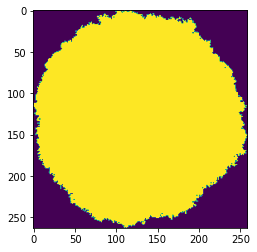

In [20]:
board = Board()
for _ in range(50_000):
    board.move()
show_board(board)

## Free edge distirubtion

In [21]:
def plot_free_edge_distribution(board):
    edges = board.candidates.values()
    _ = plt.hist(edges, bins=[0.5, 1.5, 2.5, 3.5, 4.5], density=True)
    _ = plt.xticks([1, 2, 3, 4])

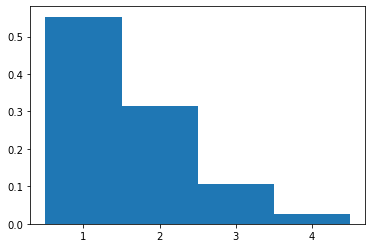

In [22]:
plot_free_edge_distribution(board)

## Hairiness

The hairiness function can now be defined with a set of squares as an argument.

In [7]:
def hairiness(board):
    return board.nr_edges/board.nr_squares

We can now write a function that plays the game for a number of time steps, and returns the hairiness as a function of time.

In [8]:
def simulate(t_max):
    board = Board()
    data = np.empty((t_max + 1, 2))
    data[0, :] = 0, hairiness(board)
    for t in range(1, t_max + 1):
        board.move()
        data[t, :] = t, hairiness(board)
    return data

Simulating over 5,000 time steps and plotting $H(t)$.

In [9]:
%%time
data = simulate(200_000)

CPU times: user 43.6 s, sys: 1.96 s, total: 45.6 s
Wall time: 48.2 s


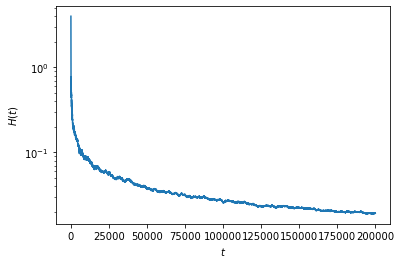

In [10]:
_ = plt.semilogy(data[:, 0], data[:, 1])
_ = plt.xlabel('$t$')
_ = plt.ylabel('$H(t)$')